# Tutorial 3: Working With Gridded Boundary Condition Data
Gridded netCDF data files are commonly supplied to TUFLOW FV as boundary conditions for parameters including atmospherics (e.g., wind), or ocean physics (e.g., temperature or residual sea surface elevation). 

For model debugging and checking of initial conditions, it is often desireable to plot comparisons of the model boundary condition data against TUFLOW FV models. To help, the `tfv` package contains a method to convert gridded datasets to *"virtual"* `TfvDomain` datasets so that familiar / like-for-like function calls can be made. 

This workflow may also be used as a "converter" to translate a gridded netCDF dataset to a standard TUFLOW FV netCDF dataset so that it can be accessed in other tools, for example the QGIS TUFLOW Viewer Plugin. 

In [1]:
import tfv.xarray

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## In Brief
The function `tfv.xarray.convert_grid_to_tfv` can be called on any standard xarray object. The keyword arguments can be used to change the way the function behaves, including if the dimension variables are not standard (i.e., standard is latitude/longitude/depth however you may have x/y/z). 

## Examples

The convert grid function is flexible and can be used with any 3D / 4D grid. For these examples, we will use HYCOM data, which is a general ocean circulation model (GOCM) that is commonly used to provide ocean boundary conditions to TUFLOW FV (e.g., ocean temperature and salinity, residual sea surface height). Other gridded data examples include atmospheric data and gridded wave conditions.

### Example 1: Loading And Plotting
This example shows how to load a HYCOM gridded netCDF file.

To get HYCOM data for your TUFLOW FV models, please see the [GetOcean tool](https://gitlab.com/tuflow-user-group/tuflow-fv/data-pre-processing/get-ocean]).

In [2]:
bc_path = Path(r'..\data')
bc_file = 'GoC_HYCOM_20100401_20100402_AEST.nc'

First we need to load the dataset. For large grid datasets (such as HYCOM, which can often be very large because it contains four dimensions), we can use Dask with Xarray to only load the data ONE timestep at a time. This means that the convert grid to tfv method will only convert the data when it is required (usually when you plot it, or if calculating statistics, etc.).

This differs from our usual recommendation to simply load datasets with the default `xr.open_dataset(file_path)`; however, this will work fine too but the conversion will take a lot longer because the data for each timestep will need to be converted right from the start.

In [3]:
ds = xr.open_dataset(bc_path / bc_file, chunks=dict(time=1))

# Usual default way - this works too but the conversion will have to convert all the data upfront which could be quite slow! 
# ds = xr.open_dataset(bc_path / bc_file)

# ds      # Uncomment to view the dataset before conversion. 

Next we will run the `convert_grid_to_tfv` function. The default options for the method will work for any gridded dataset which has the following dimensions: <br>`time, latitude, longitude, (depth)`

You will need to use the function keyword arguments if your netCDF dimensions are labelled differently to the above. For example, if your dataset has latitude labelled as `y` instead of `latitude`, you may call the function like this: `tfv.xarray.convert_grid_to_tfv(ds, y='y')`

The other keyword arguments to this method include:
- `flipz` (defaults to True), which is a flag for whether the z coordinate has been flipped. The default for most ocean models is True, i.e., depth is positive.
- `spherical` (defaults to True), which is a flag for whether the x/y coordinates are in degrees or meters. 
- `use_tfv_naming` (defaults to True), is a flag to attempt to rename variables to TFV standard names. This only works for HYCOM datasets using the GOFS 3.1 variable naming convention. For example, "water_temp" will be renamed to "TEMP". Unrecognised variable names will simply be left with their original name. 

For a HYCOM dataset that has come from the **GetOcean** tool, we can simply use all the defaults.

In [4]:
fvh = tfv.xarray.convert_grid_to_tfv(ds)
fvh

<xarray.Dataset>
Dimensions:      (Time: 3, NumLayerFaces3D: 113356, NumCells2D: 8670,
                  NumCells3D: 104686)
Coordinates:
  * Time         (Time) datetime64[ns] 2010-04-01T18:00:00 ... 2010-04-02
Dimensions without coordinates: NumLayerFaces3D, NumCells2D, NumCells3D
Data variables:
    ResTime      (Time) float64 1.775e+05 1.775e+05 1.775e+05
    layerface_Z  (Time, NumLayerFaces3D) float32 0.0 -1.0 -3.0 ... -5.0 -7.0
    stat         (Time, NumCells2D) int32 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1
    H            (Time, NumCells2D) float32 dask.array<chunksize=(1, 8670), meta=np.ndarray>
    V_x          (Time, NumCells3D) float32 dask.array<chunksize=(1, 104686), meta=np.ndarray>
    V_y          (Time, NumCells3D) float32 dask.array<chunksize=(1, 104686), meta=np.ndarray>
    TEMP         (Time, NumCells3D) float32 dask.array<chunksize=(1, 104686), meta=np.ndarray>
    SAL          (Time, NumCells3D) float32 dask.array<chunksize=(1, 104686), meta=np.ndarray>
Attributes:
    Origin:     Created by `tfv` python tools using `grid_to_tfv`
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

We can now treat this dataset as a usual `TfvDomain` object, such as plotting, getting timeseries data, doing statistics, etc. 

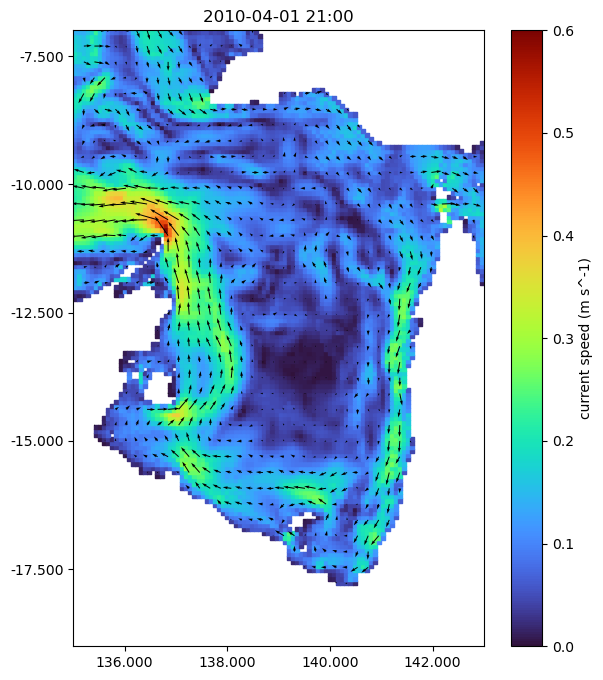

In [5]:
time = '2010-04-01 21:00'

fig, ax = plt.subplots(figsize=(7, 8))
ax.set_aspect('equal')

fvh.plot('V', time, ax=ax, cmap='turbo', clim=(0,0.6))
fvh.plot_vector(time=time, ax=ax)

plt.show()

A final advantage of this method is that the converted dataset can now be exported as a new netCDF in a standard TUFLOW FV format. This netCDF can then be used in other applications such as QGIS with the TUFLOW Viewer Plugin.

### Example 2: Displaying HYCOM And TUFLOW FV Models
As an extension of Example 1, we can overlay TUFLOW FV results over the top of the HYCOM dataset to get insight into how the boundary condition is influencing the model. 

*Note - we don't expect to see the two look completely similar because of the many differences between the two models, for example, GOCM's like HYCOM do not consider tidal forcing.*

In [11]:
tfv_path = Path(r'..\data')
tfv_file = "CST008_3D_001_20100401_20100402.nc"    # trimmed to April 1st 8pm to 10pm for download package.

In [7]:
fv = xr.open_dataset(tfv_path / tfv_file).tfv

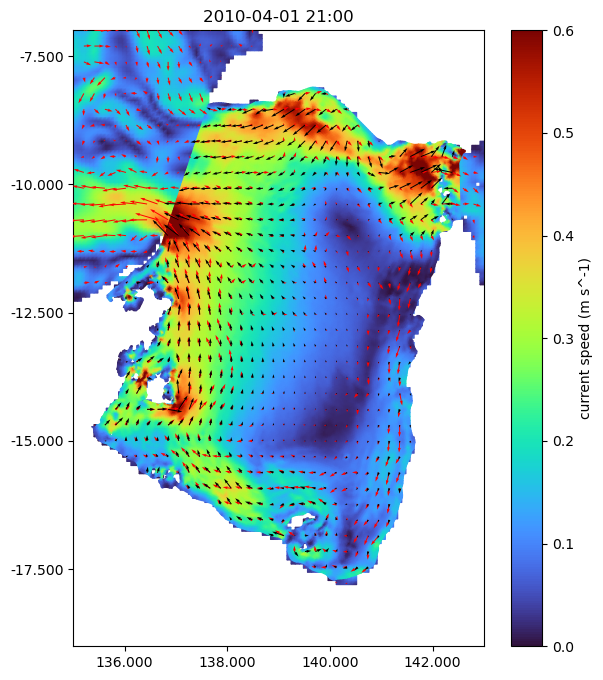

In [8]:
time = '2010-04-01 21:00'

cspec = dict(cmap='turbo', clim=(0,0.6), shading='interp')

fig, ax = plt.subplots(figsize=(7, 8))
ax.set_aspect('equal')

fvh.plot('V', time, ax=ax, colorbar=False, **cspec)
fvh.plot_vector(time=time, ax=ax, color='red', lw=2)

fv.plot('V', time, ax=ax, **cspec)
fv.plot_vector(time=time, ax=ax, lw=2)

plt.show()

**Note: The above plot could also be created interactively using the `plot_interactive` function**

With GOCM model boundary conditions, we are often interested in how the physical ocean parameters like salinity and temperature transfer into the model.

A common way to view how these parameters are coming into the model is to use plots that show depth, such as curtains. 

First we'll load a polyline to extract a curtain along. In the latest version of `tfv` (1.0.6 onwards), shapely LineString objects are supported, provided that shapely is installed (it is not a requirement of tfv). The cell below has a LineString shape in a Well Known Text (WKT) format, a common GIS format for vectors - this line has been copy/pasted out of QGIS. The following line then converts this WKT string to a shapely object. The final line shows how to convert from shapely to a simple numpy array of coordinates (we use this for plotting the line later). 

In [9]:
import shapely.wkt
wkt_line = 'LineString (136.68613903058050596 -9.59936645056413873, 137.62092265616959708 -10.85511867846290812, 138.34797658718332514 -12.45357579210434551, 138.51119277577822686 -13.8550416176278528, 138.28862524587609073 -15.24822723860463114)'

shapely_polyline = shapely.wkt.loads(wkt_line)
polyline = np.stack(shapely_polyline.xy).T

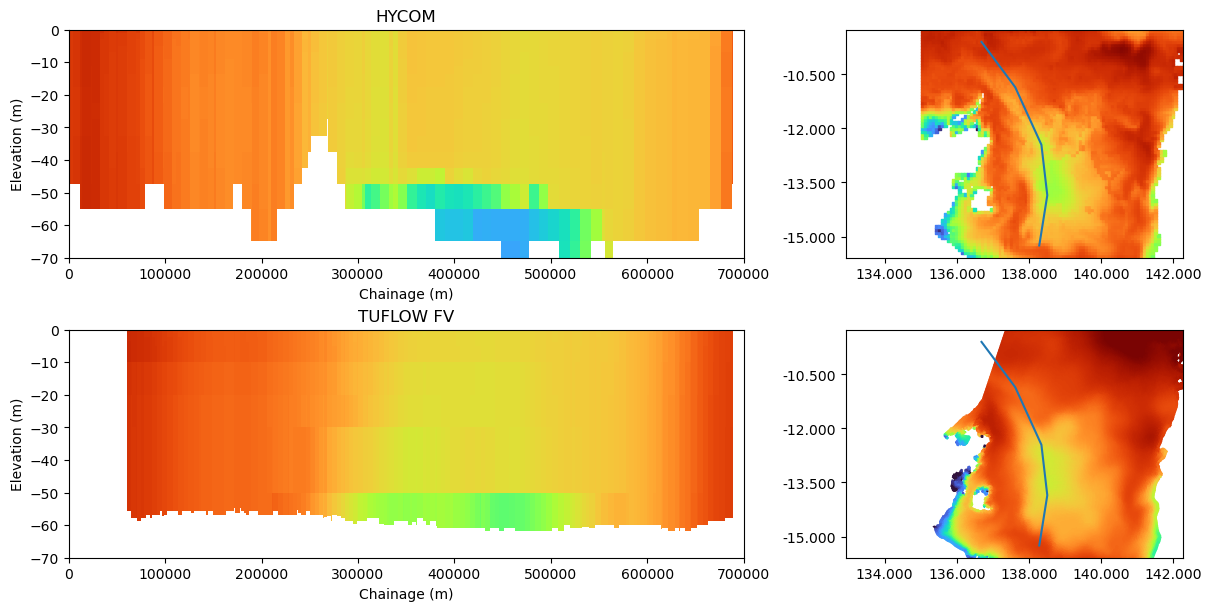

In [10]:
# Simple transect
time = '2010-04-02 12:00'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), constrained_layout=True, width_ratios=[2, 1])
cspec = dict(cmap='turbo', clim=(26,30))

# Row 1 - HYCOM
axes[0][1].set_aspect('equal', adjustable='datalim')
axes[0][1].plot(polyline[:, 0], polyline[:, 1])
fvh.plot('TEMP', time, ax=axes[0][1], colorbar=False, **cspec) # Spatial map, top right

fvh.plot_curtain(shapely_polyline, 'TEMP', time, ax=axes[0][0], colorbar=False, **cspec) # Curtain
axes[0][0].set_xlim(0, None)

# Row 2 - TUFLOW FV
axes[1][1].set_aspect('equal', adjustable='datalim')
axes[1][1].plot(polyline[:, 0], polyline[:, 1])
fv.plot('TEMP', time, ax=axes[1][1], colorbar=False, **cspec) # Spatial map, top right

fv.plot_curtain(shapely_polyline, 'TEMP', time, ax=axes[1][0], colorbar=False, **cspec) # Curtain

for n, lbl in enumerate(['HYCOM', 'TUFLOW FV']):
    axes[n][0].set_xlim(0, 700000)
    axes[n][0].set_ylim(-70, 0)
    axes[n][0].set_title(lbl)
    axes[n][1].set_title('')

plt.show()